# Grupo 14

In [ ]:
!pip install ortools

# Problema 1 : Horário de reuniões de uma “StartUp” 

A StartUp pussui $S$ salas, $C$ colaboradores, $P$ projetos e trabalha $T$ tempos durante $D$ dias. 

Para simplificar o código, identificaremos os colaboradores e os projetos, respetivamente, pelos índice $c ∈ [0..C−1]$ e $p ∈ [0..P−1]$.

Já para identificar cada sala disponível num dado dia, a um dado tempo, iremos utilizar o triplo $(s,d,t) ∈ [0..S−1]\times[0..D−1]\times[0..T−1] $. Iremos, ainda,usar uma família $x_{c,p,s,d,t}$ de variáveis binárias. 
 
Para abordamos a disponibilidade dos colaboradores, criamos um dicionário que para cada um destes indica os dias e horas em que cada um está disponível. Sendo que a disponibilidade, pode variar entre 0 ou 1. 

Relativamente aos requisitos do horário, organizamos estes em três categorias:

$Limitações$
* Cada reunião ocupa uma sala.
$$\forall_{d<D} \cdot \forall_{t<T} \cdot \forall_{c<C} \quad \sum_{s<S} x_{c,p,s,d,t} \leq 1$$

* Cada sala só pode estar designada para exatamente um projeto. 

$$\forall_{s<S} \cdot \forall_{d<D} \cdot \forall_{t<T} \cdot \forall_{c<C} \quad \sum_{p<P} x_{c,p,s,d,t} ==1$$

* Não há reuniões do mesmo projeto, à mesma hora, noutra sala.

$$\forall_{d<D} \cdot \forall_{t<T} \cdot \forall_{p<P} \cdot \forall_{c<C} \quad \sum_{s<S} x_{c,p,s,d,t} ==1$$

$Obrigações$
*  No mínimo, 50\% do total de colaboradores do projeto têm de participar na reunião.

$$\forall_{s<S} \cdot \forall_{p<P} \cdot \forall_{d<D} \cdot \forall_{h<H} \quad \sum_{c<C} x_{c,p,s,d,t} \geq 0.5\times c$$

$Outras$ $condições$

Consideremos a variável $P_{info}$ que corresponde ao dicionário com a informação relativa aos diferentes projetos, ou seja, ao seu líder e respetivos colaboradores. 

* O líder do projeto participa em todas as reuniões do seu projeto.

$$\forall_{s<S} \cdot \forall_{p<P} \cdot \forall_{d<D} \cdot \forall_{t<T} \quad \sum_{c<C} P_{info}[1]== 1$$

Consideremos a variável $Col_{dis}$ que corresponde ao dicionário com a informação relativa à disponibilidade dos diferentes colaboradores. 

* Os colaboradores podem ou não participar numa reunião, consoante a sua disponibilidade.

$$\forall_{s<S} \cdot \forall_{d<D} \cdot \forall_{h<H} \cdot \forall_{p<P} \quad \sum_{c<C} Col_{dis}(c)\leq 1$$

In [ ]:
from ortools.sat.python import cp_model

col_disponibilidade = {"C1":[("segunda",1),("terça",4),("sexta",3)], "C2":[("terça",4),("sexta",3)],"C3":[("segunda",1),("sexta",3)], "C4":[("terça",4),("sexta",3)]}

cols = ["C1","C2","C3","C4"]
dias = ["segunda","terça","quarta","quinta","sexta"]
horas = [1,2,3,4]

salas = ["S1","S2","S3"]

projetos = ["P1","P2"]
projetos_info = {"P1":(["C1","C2"],"C1",2), "P2":(["C3","C4"],"C3",1)}


def define_horario():    
    # Criação do modelo
    model = cp_model.CpModel()

    horario = {}
    
    for sala in salas:
      for dia in dias:
        for hora in horas:        
          for projeto in projetos:
              for col in projetos_info[projeto][0]:
                horario[(sala, dia, hora, projeto, col)] = model.NewBoolVar('horario_sala%sdia%shora%iprojeto%scol%s' % (sala, dia, hora, projeto, col))

    # Cada sala e "slot" só podem ser designadas para um projeto no horário 
    for sala in salas:
      for dia in dias:
        for hora in horas:
          model.Add(sum(horario[(sala, dia, hora, projeto, projetos_info[projeto][1])] for projeto in projetos) <= 1)

    # Não há reuniões do mesmo projetos a acontecerem ao mesmo tempo
    for dia in dias:
      for hora in horas:
        for projeto in projetos:
          lider =  projetos_info[projeto][1]
          model.Add(sum(horario[(sala, dia, hora, projeto, lider)] for sala in salas) <= 1)

    # Existem um certo número de reuniõe para cada projeto 
    for projeto in projetos:
      lider =  projetos_info[projeto][1]
      model.Add(sum(horario[(sala, dia, hora, projeto,lider)] for sala in salas for dia in dias for hora in horas) == projetos_info[projeto][2])

    # O líder tem que estar presente em todas as reuniões
    for sala in salas:
      for dia in dias:
         for hora in horas:
           for projeto in projetos:
             for col in projetos_info[projeto][0]:
               lider =  projetos_info[projeto][1]
               model.Add(horario[(sala, dia, hora, projeto, lider)] >= horario[(sala, dia, hora, projeto, col)])
  
    # 50% dos colaboradores têm de estar presentes na reunião 
    for sala in salas:
      for dia in dias:
        for hora in horas:
          for projeto in projetos:
            lider =  projetos_info[projeto][1]
            model.Add(sum(horario[(sala, dia, hora, projeto, col)] for col in projetos_info[projeto][0]) >= int(len(projetos_info[projeto][0])*0.5)).OnlyEnforceIf(horario[(sala, dia, hora, projeto, lider)])
    
    # A disponibilidade varia entre 0 ou 1
    disponibilidade = {}
    for col in cols:
      for dia in dias:
        for hora in horas: 
          if (dia, hora) in col_disponibilidade[col]:
            disponibilidade[(dia, hora, col)] = 1
          else:
            disponibilidade[(dia, hora,col)] = 0


    # O horário tem que estar de acordo com a disponibilidade dos colaboradores 
    for sala in salas:
      for dia in dias:
        for hora in horas:        
          for projeto in projetos:
            for col in projetos_info[projeto][0]:
              model.Add(horario[(sala,dia, hora, projeto, col)] <= disponibilidade[(dia,hora,col)])
    
    
    # Maximizar o maior núemro de pessoas presentes
    model.Maximize(sum(horario[(sala, dia, hora, projeto, col)] for projeto in projetos for col in projetos_info[projeto][0] for sala in salas for dia in dias for hora in horas ))
    

    # Criar instância do solver
    solver = cp_model.CpSolver()
    status = solver.Solve(model) 

    if status == cp_model.OPTIMAL:
        print('Solution:')
        for dia in dias:
          #print('Dia:', dia)
          for sala in salas:
            #print('Sala:', sala)
            for hora in horas:
              #print('Hora:', hora)
              for projeto in projetos:
                for col in projetos_info[projeto][0]:
                  if (solver.Value(horario[(sala, dia, hora, projeto,col)])):
                    print("Dia: " + dia + " Sala:" + sala +" Hora: " + str(hora) + " Projeto: " + projeto + " Col: " + col)
       
    else:
        print('No optimal solution found !')

    return status


define_horario()


Solution:
Dia: terça Sala:S1 Hora: 4 Projeto: P1 Col: C1
Dia: terça Sala:S1 Hora: 4 Projeto: P1 Col: C2
Dia: sexta Sala:S1 Hora: 3 Projeto: P2 Col: C3
Dia: sexta Sala:S1 Hora: 3 Projeto: P2 Col: C4
Dia: sexta Sala:S3 Hora: 3 Projeto: P1 Col: C1
Dia: sexta Sala:S3 Hora: 3 Projeto: P1 Col: C2


4

# Teste Exemplo

Consideremos que existem 4 colaboradores, que iremos designar de C1, C2, C3 e C4, cujas disponibilidades correspondem ao seguinte dicionário: {"C1": [("segunda",1), ("terça",4), ("sexta",3)], "C2": [("terça",4), ("sexta",3)],"C3":[("segunda",1), ("sexta",3)], "C4":[("terça",4), ("sexta",3)]}. Imaginemos que durante os cinco dias da semana, com 4h disponíveis para reuniões por dia e três salas, S1, S2 e S3, existem 3 projetos, o P1 e o P2, que têm as seguintes informações: {"P1":(["C1","C2"],"C1",2), "P2":(["C3","C4"],"C3",1)}. A partir destes dados, obtivemos o seguinte horário:

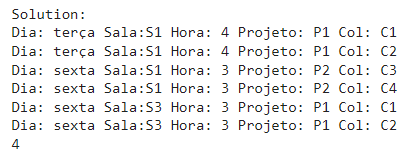

Já para quatro colaboradores com a seguinte dispobilidade: {"C1":[("segunda",1), ("terça",4), ("sexta",3)], "C2":[("terça",4), ("sexta",3)],"C3":[("segunda",1), ("sexta",3)], "C4":[("terça",4), ("sexta",3)],"C5":[("segunda",5), ("quarta",3), ("quinta",1)], "C6":[("segunda",5), ("quinta",1), ("sexta",3)]},com as sala de reuniões disponíveis durante 6 horas toda a semana e com 3 projetos, cuja informação é a seguinte: {"P1":(["C1","C2"],"C1",2), "P2":(["C3","C4"],"C3",1),"P3":(["C5","C6"],"C5",2)}. Obtivemos a solução abaixo.

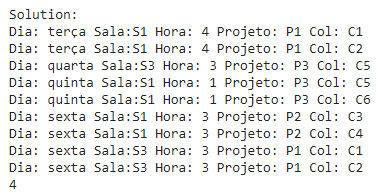